In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

In [3]:
sns.set_style("white")

In [4]:
# Display figures at a reasonable default size.
mpl.rcParams['figure.figsize'] = (6, 4)

# Disable top and right spines.
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
    
# Display and save figures at higher resolution for presentations and manuscripts.
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 300

# Display text at sizes large enough for presentations and manuscripts.
mpl.rcParams['font.weight'] = "normal"
mpl.rcParams['axes.labelweight'] = "normal"
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

## Load data

Load exhaustive grid search data. For each possible embedding method, corresponding method parameters, and HDBSCAN distance threshold, we produced an embedding for training and validation data (using 2-fold validation with 3 repeats for N=6 cross-validation iterations per parameter combination), assigned clusters to each embedding, and evaluated how well all pairs of strains in the data were assigned to the same or different cluster compared to predetermined clade assignments.

In [6]:
grid = pd.read_csv(snakemake.input.table, sep="\t")
#grid = pd.read_csv("../seasonal-flu-nextstrain/results/gridsearch.tsv", sep="\t")

In [7]:
grid.head()

,n_components,svd_solver,random_state,method,cv_iteration,distance_threshold,training_mcc,training_tn,training_fn,training_tp,...,dissimilarity,n_init,n_jobs,perplexity,learning_rate,metric,square_distances,n_neighbors,min_dist,init
0,10.0,full,12883823,pca,0,0.0,0.141983,369907,43926,11901,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.0,full,12883823,pca,1,0.0,0.203845,384642,40750,11667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,full,12883823,pca,2,0.0,0.144170,367254,40034,12665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.0,full,12883823,pca,3,0.0,0.255921,388550,42684,12549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.0,full,12883823,pca,4,0.0,0.215857,378046,40571,13954,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
list(grid.columns)

['n_components',
 'svd_solver',
 'random_state',
 'method',
 'cv_iteration',
 'distance_threshold',
 'training_mcc',
 'training_tn',
 'training_fn',
 'training_tp',
 'training_fp',
 'validation_tn',
 'validation_fn',
 'validation_tp',
 'validation_fp',
 'validation_mcc',
 'dissimilarity',
 'n_init',
 'n_jobs',
 'perplexity',
 'learning_rate',
 'metric',
 'square_distances',
 'n_neighbors',
 'min_dist',
 'init']

## Identify the distance threshold that maximized the training accuracy

We want to identify the distance threshold for HDBSCAN cluster assignment that produces the most accurate clusters (based on known clade assignments) across each method. To find this optimal threshold, we calculate the mean training MCC value across all cross-validation iterations for a given method and set of method parameters and find the threshold that maximizes this mean across each method.

In [9]:
mean_training_mcc_by_method = grid.groupby(["method", "distance_threshold"])["training_mcc"].mean().reset_index()

In [10]:
mean_training_mcc_by_method

,method,distance_threshold,training_mcc
0,mds,0.0,0.161444
1,mds,2.0,0.601569
2,mds,4.0,0.422491
3,mds,6.0,0.144298
4,mds,8.0,0.143438
5,mds,10.0,0.109825
6,mds,12.0,0.109825
7,mds,14.0,0.109825
8,pca,0.0,0.201057
9,pca,2.0,0.568973


NameError: name 'snakemake' is not defined

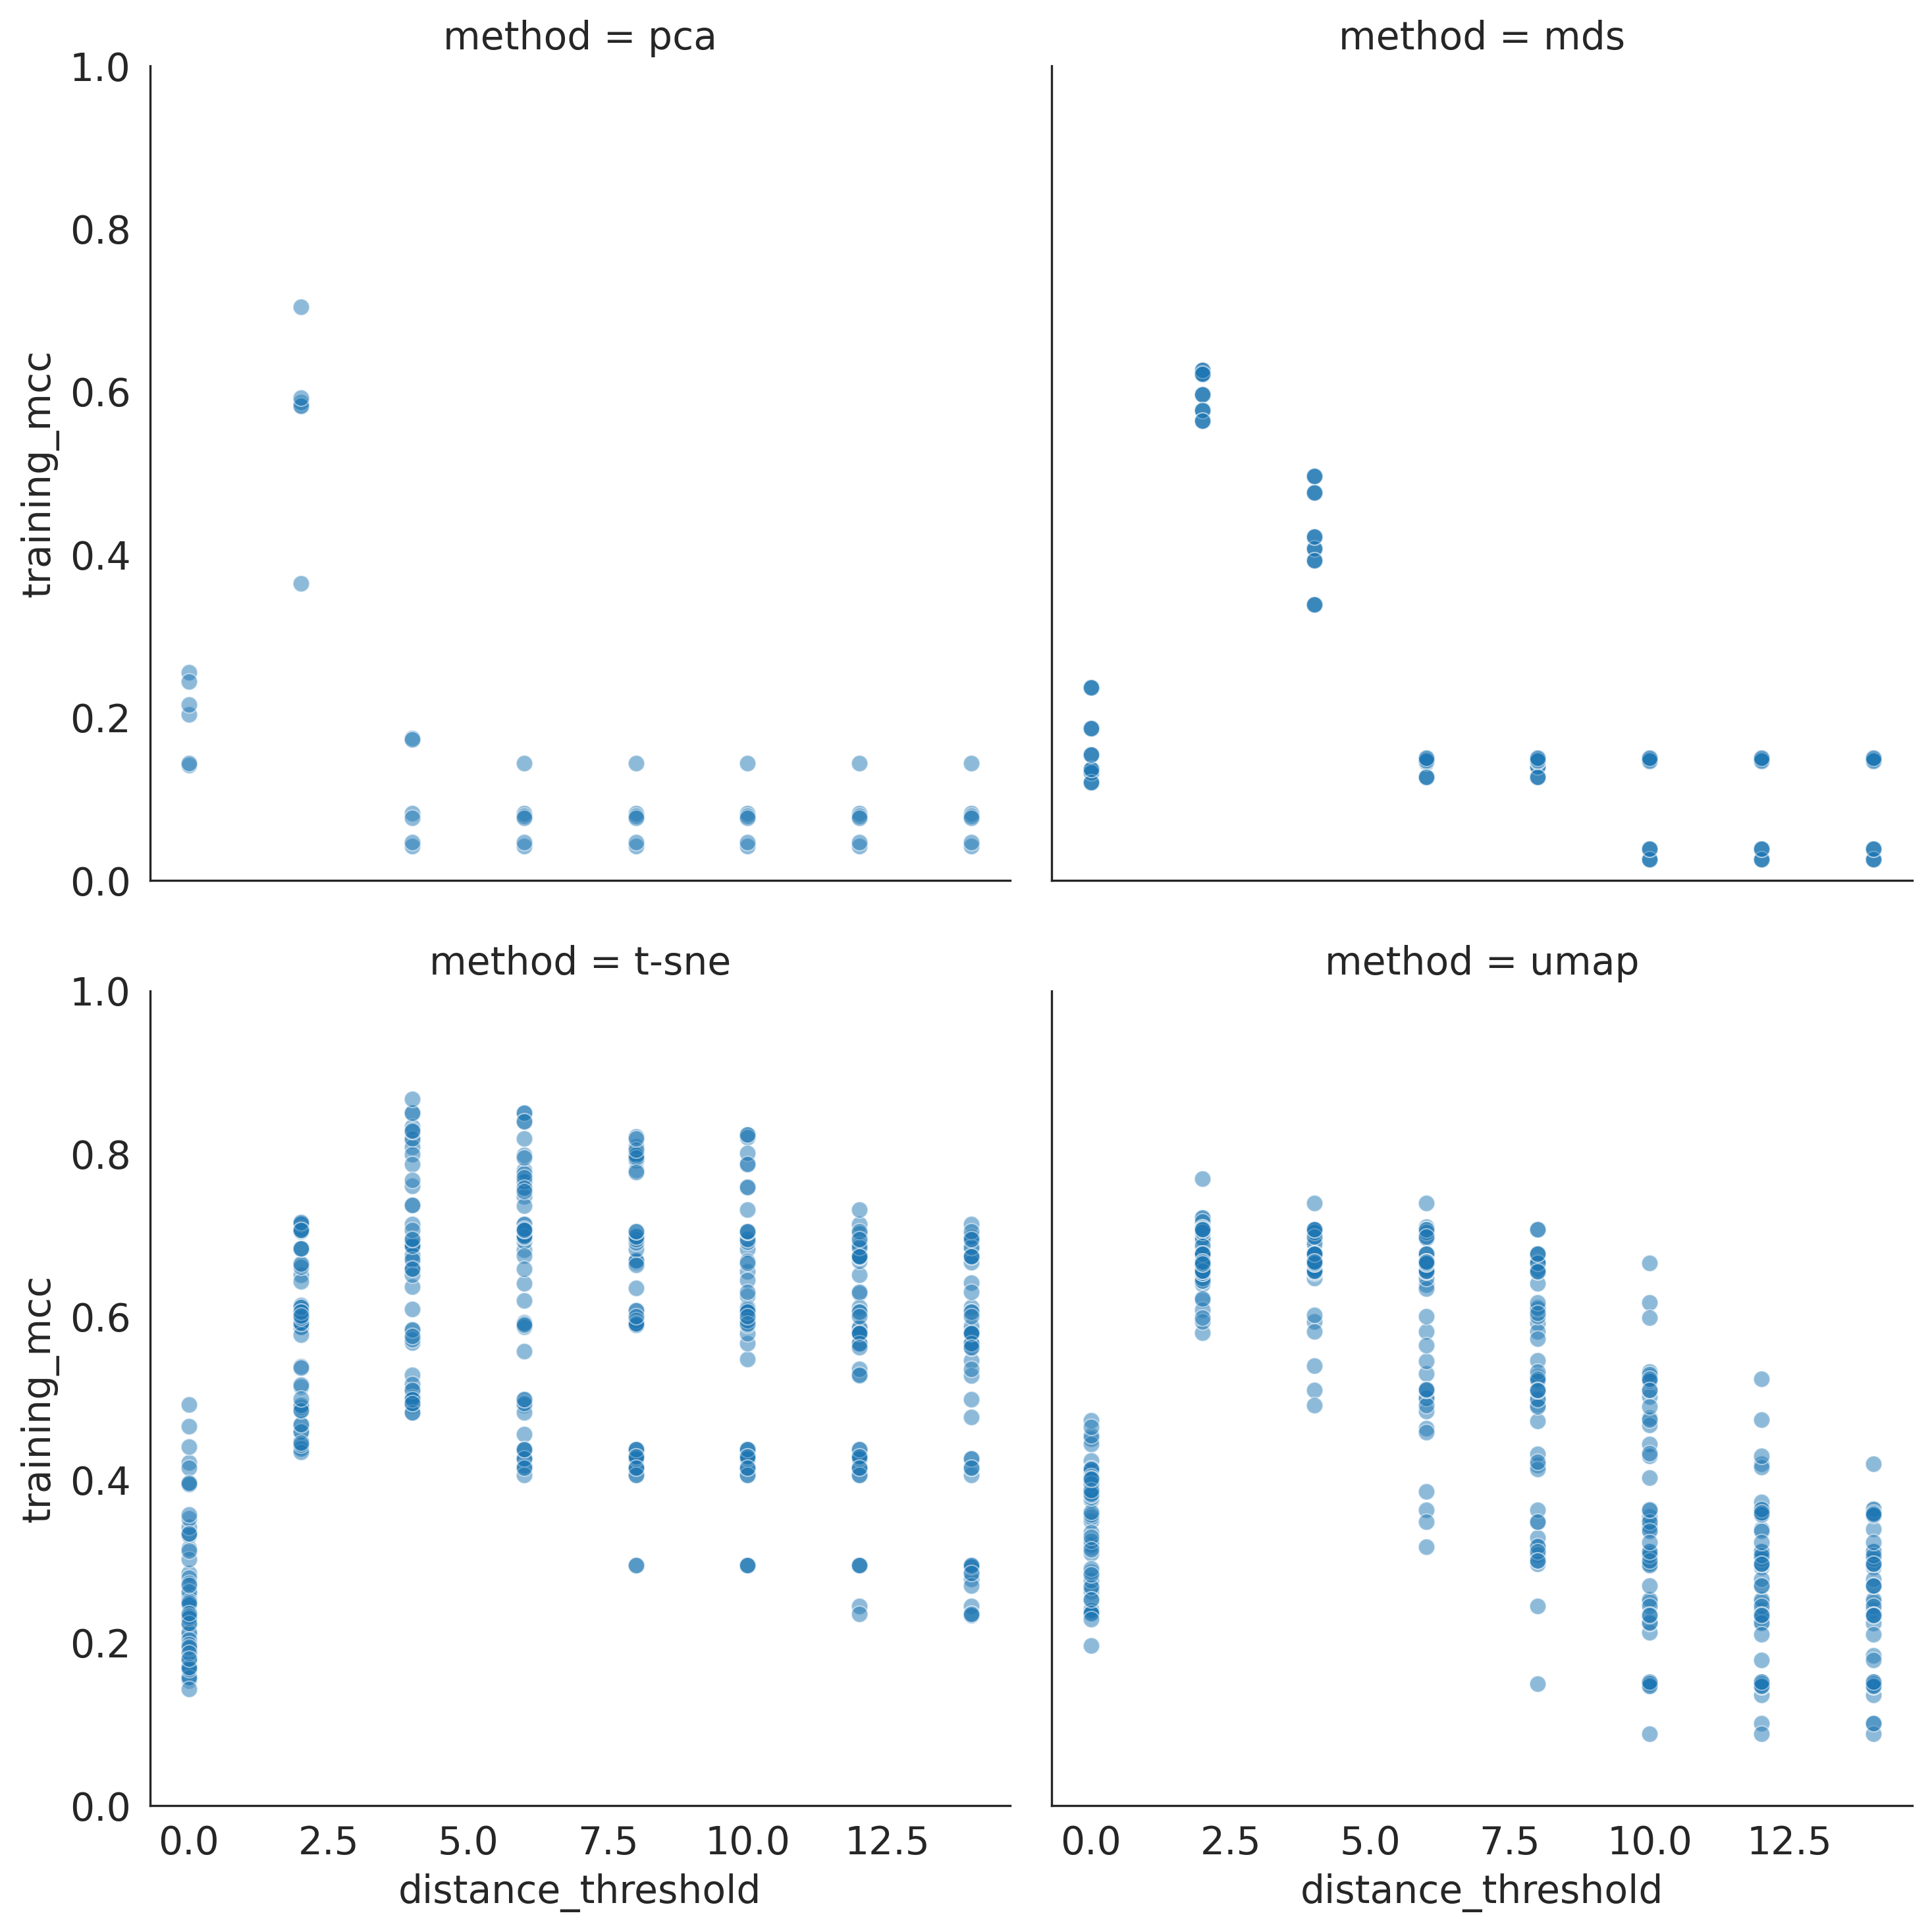

In [11]:
facet_grid = sns.relplot(
    data=grid,
    x="distance_threshold",
    y="training_mcc",
    col="method",
    col_wrap=2,
    alpha=0.5,
)

for ax in facet_grid.axes.flatten():
    ax.set_ylim(0, 1)
    
plt.tight_layout()
plt.savefig(snakemake.output.mcc_by_method_and_distance_threshold)

Calculate the mean training MCC for each method and distance threshold across all cross-validation iterations. The maximum mean training MCC per method identifies the optimal distance threshold for that method.

In [15]:
training_mcc = grid.groupby(["method", "distance_threshold"]).aggregate(
    {"training_mcc": ["mean", "std"]}
).reset_index().droplevel(1, axis=1).set_axis(
    ["method", "distance_threshold", "training_mcc_mean", "training_mcc_stddev"],
    axis="columns"
)

In [16]:
training_mcc

,method,distance_threshold,training_mcc_mean,training_mcc_stddev
0,mds,0.0,0.161444,0.041050
1,mds,2.0,0.601569,0.024816
2,mds,4.0,0.422491,0.053906
3,mds,6.0,0.144298,0.008093
4,mds,8.0,0.143438,0.008251
5,mds,10.0,0.109825,0.056296
6,mds,12.0,0.109825,0.056296
7,mds,14.0,0.109825,0.056296
8,pca,0.0,0.201057,0.048695
9,pca,2.0,0.568973,0.110845


In [17]:
max_training_mcc = training_mcc.sort_values([
    "method",
    "training_mcc_mean"
], ascending=False).groupby(
    "method",
    sort=False
).first().reset_index()

In [18]:
max_training_mcc

,method,distance_threshold,training_mcc_mean,training_mcc_stddev
0,umap,2.0,0.669844,0.034535
1,t-sne,4.0,0.650561,0.122661
2,pca,2.0,0.568973,0.110845
3,mds,2.0,0.601569,0.024816


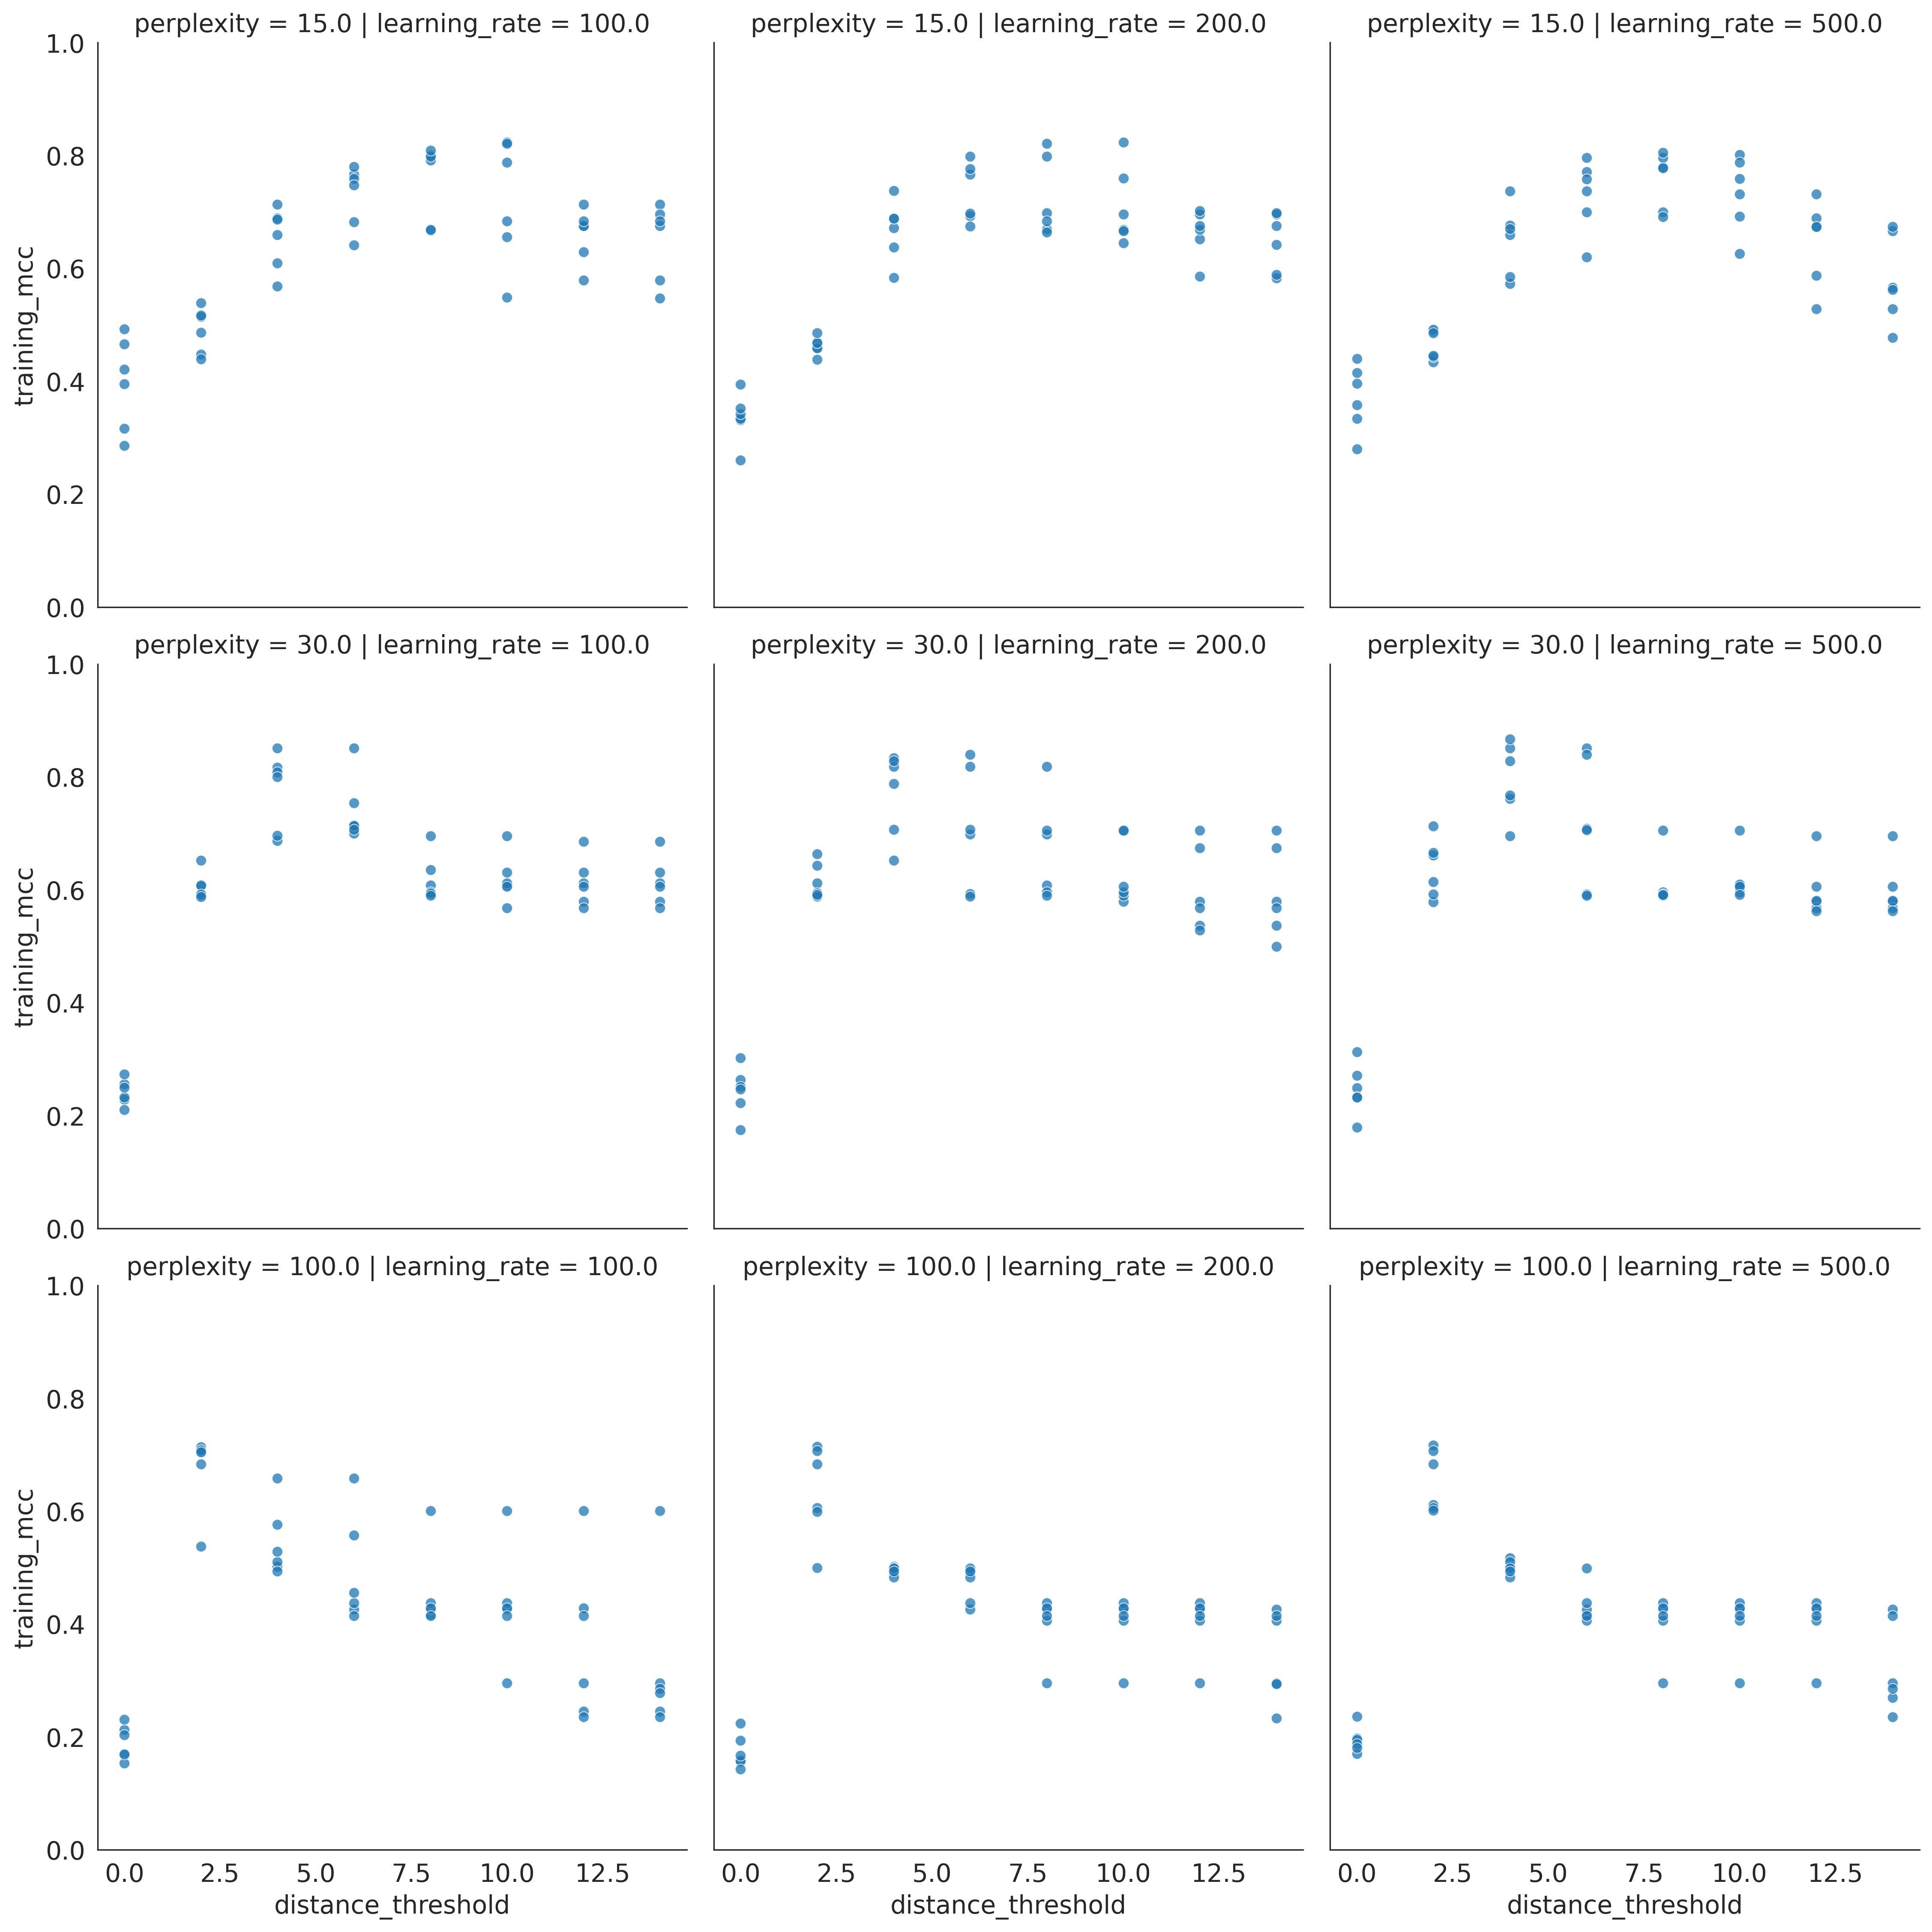

In [19]:
if "perplexity" in grid.columns:
    facet_grid = sns.relplot(
        data=grid.query("method == 't-sne'"),
        x="distance_threshold",
        y="training_mcc",
        col="learning_rate",
        row="perplexity",
        alpha=0.75,
    )

    for ax in facet_grid.axes.flatten():
        ax.set_ylim(0, 1)

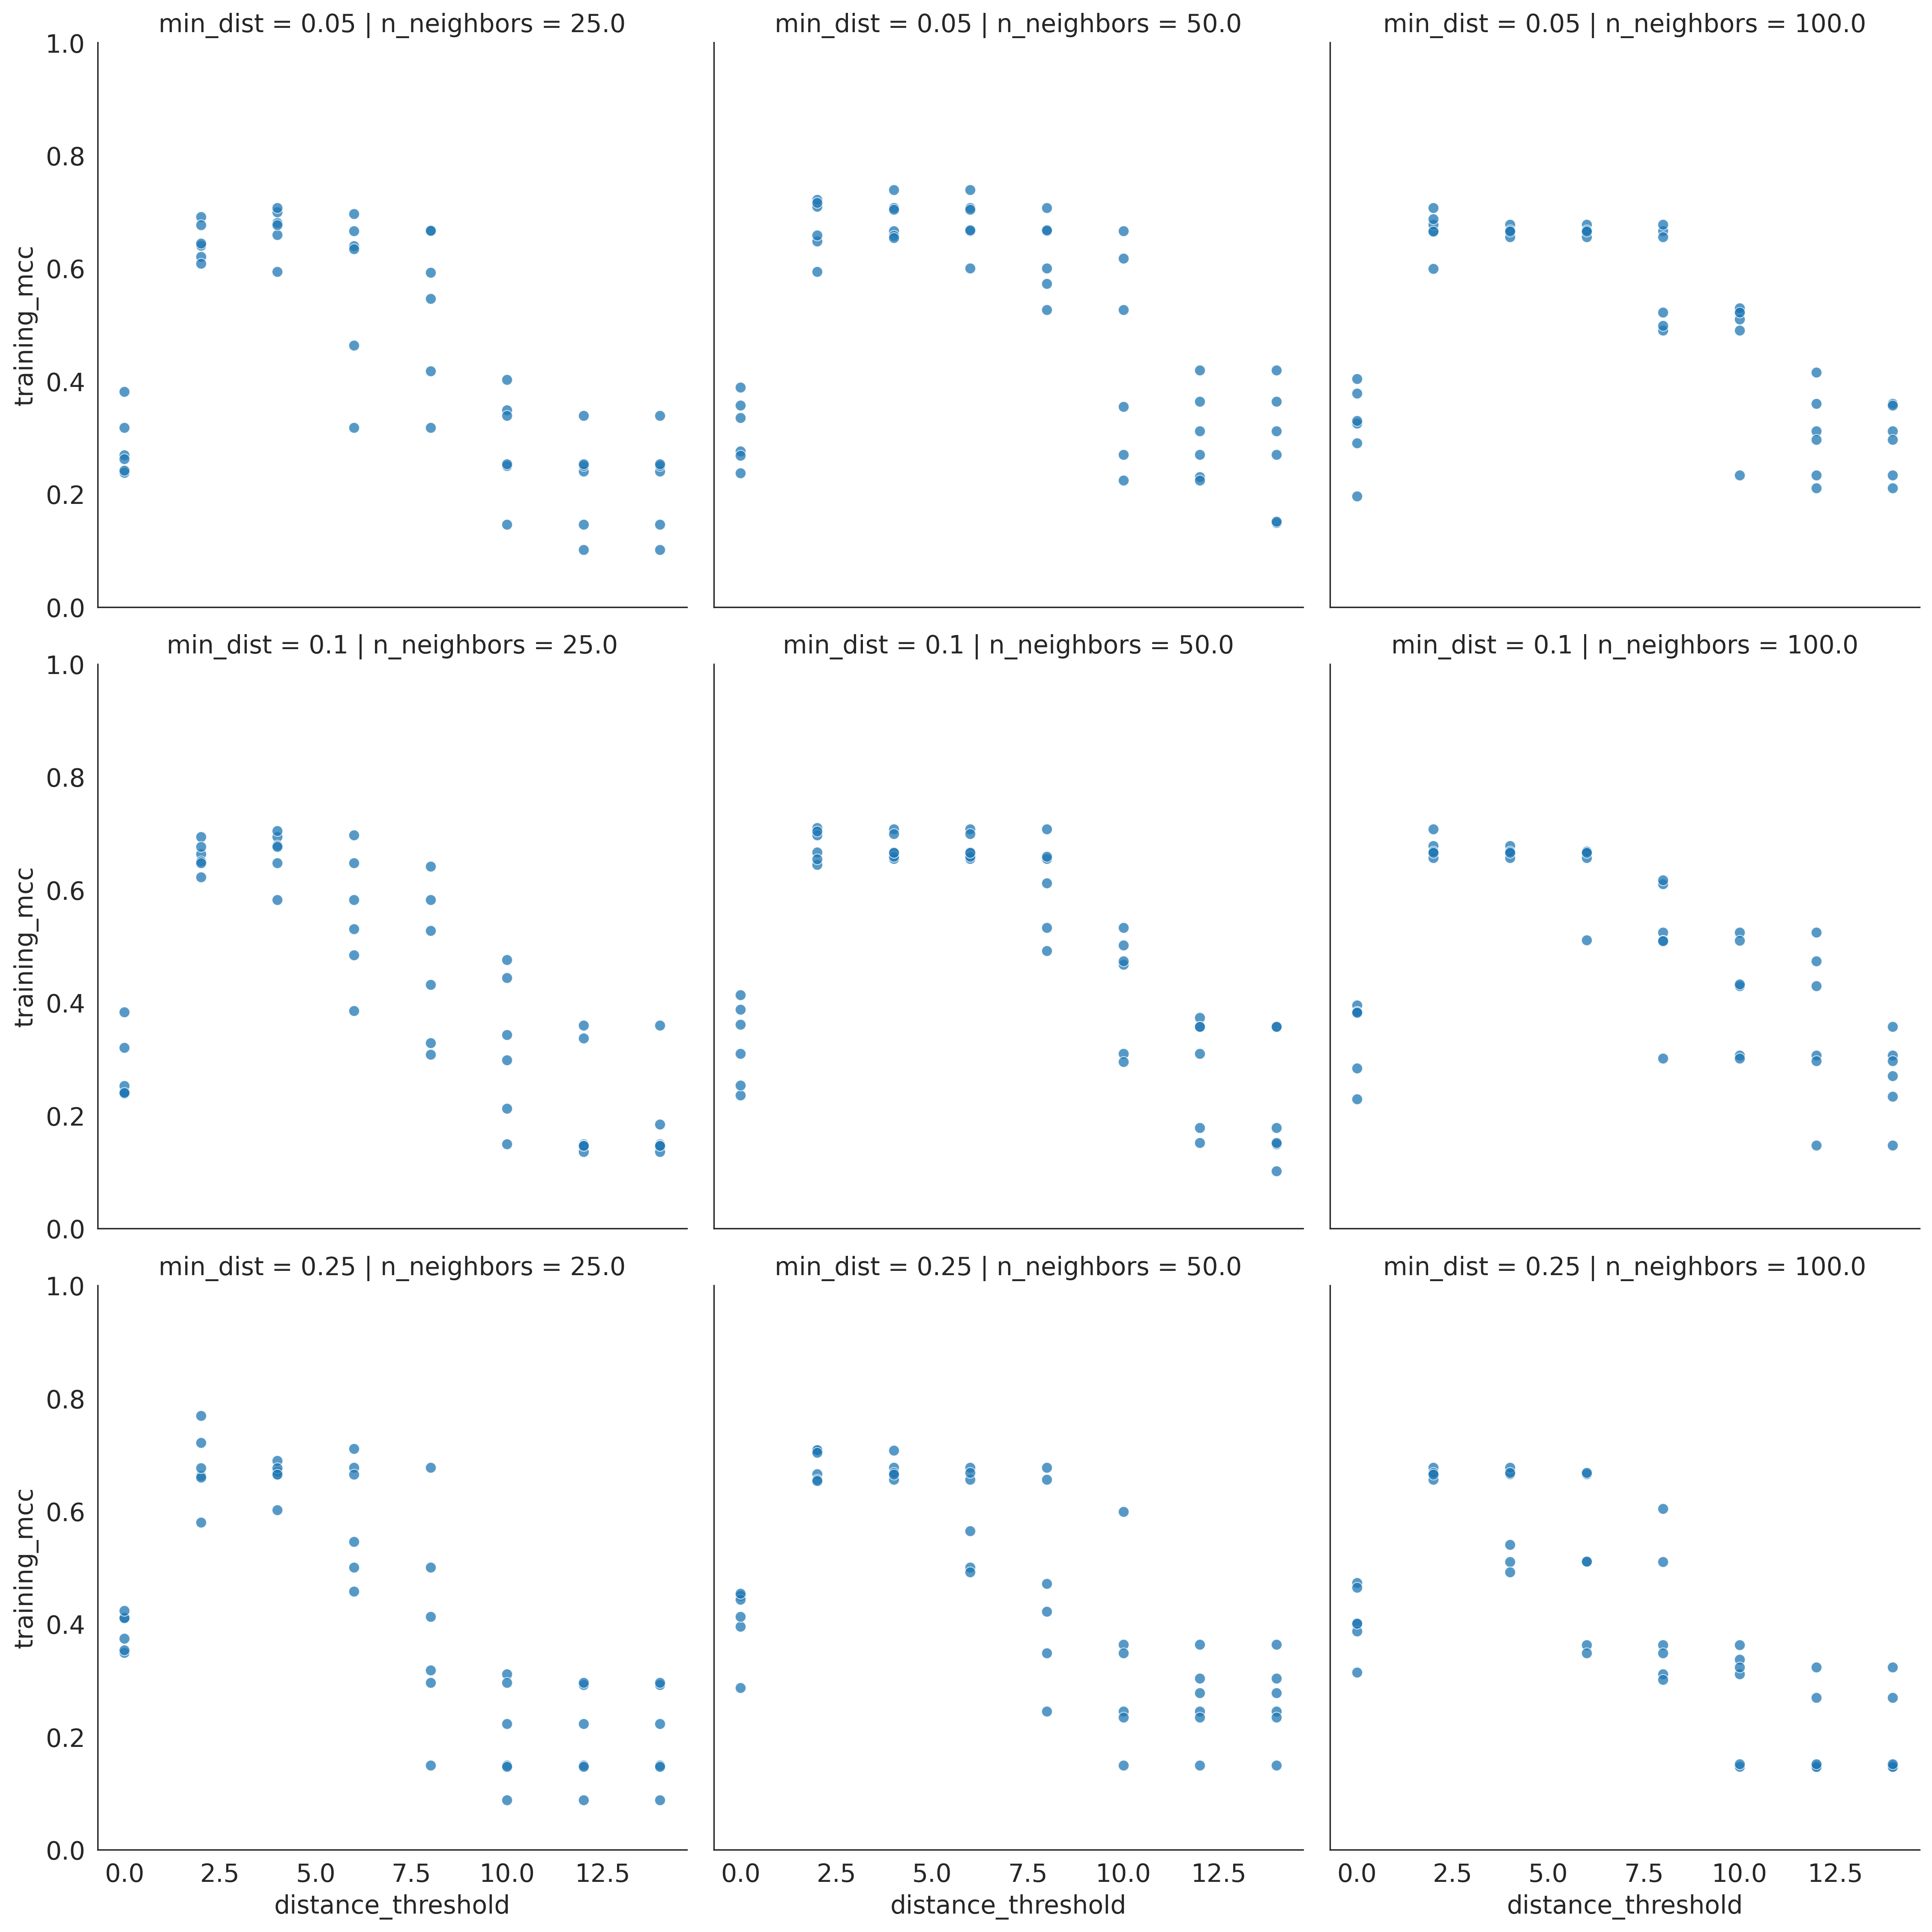

In [20]:
if "min_dist" in grid.columns:
    facet_grid = sns.relplot(
        data=grid.query("method == 'umap'"),
        x="distance_threshold",
        y="training_mcc",
        col="n_neighbors",
        row="min_dist",
        alpha=0.75,
    )

    for ax in facet_grid.axes.flatten():
        ax.set_ylim(0, 1)

### PCA

In [21]:
pca_max_training_mcc = max_training_mcc.query("method == 'pca'")

In [22]:
pca_max_training_mcc

,method,distance_threshold,training_mcc_mean,training_mcc_stddev
2,pca,2.0,0.568973,0.110845


In [23]:
try:
    pca_max_training_mcc.to_csv(
        snakemake.output.pca_parameters,
        index=False,
    )
except:
    print("does not exist")

does not exist


### MDS

In [24]:
mds_max_training_mcc = max_training_mcc.query("method == 'mds'")

In [25]:
mds_grid = mds_max_training_mcc.merge(
    grid,
    on=["method", "distance_threshold"]
)

In [26]:
mds_grid.head()

,method,distance_threshold,training_mcc_mean,training_mcc_stddev,n_components,svd_solver,random_state,cv_iteration,training_mcc,training_tn,...,dissimilarity,n_init,n_jobs,perplexity,learning_rate,metric,square_distances,n_neighbors,min_dist,init
0,mds,2.0,0.601569,0.024816,2.0,NaN,12883823,0,0.596791,366929,...,precomputed,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mds,2.0,0.601569,0.024816,2.0,NaN,12883823,1,0.622361,367690,...,precomputed,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,mds,2.0,0.601569,0.024816,2.0,NaN,12883823,2,0.577354,368097,...,precomputed,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mds,2.0,0.601569,0.024816,2.0,NaN,12883823,3,0.626941,368383,...,precomputed,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mds,2.0,0.601569,0.024816,2.0,NaN,12883823,4,0.564199,367626,...,precomputed,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
try:
    mds_mean_validation_mcc = mds_grid.groupby([
        "method",
        "distance_threshold",
        "n_components"
    ])["validation_mcc"].mean().reset_index().sort_values(
        "validation_mcc",
        ascending=False
    )
except:
    mds_mean_validation_mcc = mds_grid.groupby([
        "method",
        "distance_threshold"
    ])["validation_mcc"].mean().reset_index().sort_values(
        "validation_mcc",
        ascending=False
    )

In [29]:
mds_mean_validation_mcc

,method,distance_threshold,n_components,validation_mcc
0,mds,2.0,2.0,0.601569


In [30]:
mds_max_validation_mcc = mds_mean_validation_mcc.sort_values("validation_mcc", ascending=False).head(1)

In [ ]:
mds_max_validation_mcc

In [ ]:
try:
    mds_max_validation_mcc.to_csv(
        snakemake.output.mds_parameters,
        index=False,
    )
except:
    print("not a parameter")

## Identify optimal method parameter values

Given the distance threshold that maximizes the training MCC above (threshold=4 for t-SNE and threshold=2 for UMAP), we next identify the combination of method parameters that maximizes the validation MCC for that distance threshold.

### t-SNE

In [ ]:
tsne_max_training_mcc = max_training_mcc.query("method == 't-sne'")

In [ ]:
tsne_grid = tsne_max_training_mcc.merge(
    grid,
    on=["method", "distance_threshold"]
)

In [ ]:
tsne_grid.head()

In [ ]:
try:
    tsne_mean_validation_mcc = tsne_grid.groupby([
        "method",
        "distance_threshold",
        "perplexity",
        "learning_rate"
    ])["validation_mcc"].mean().reset_index().sort_values(
        "validation_mcc",
        ascending=False
    )
except:
    tsne_mean_validation_mcc = tsne_grid.groupby([
        "method",
        "distance_threshold"
    ])["validation_mcc"].mean().reset_index().sort_values(
        "validation_mcc",
        ascending=False
    )

In [ ]:
tsne_mean_validation_mcc

In [ ]:
tsne_max_validation_mcc = tsne_mean_validation_mcc.sort_values("validation_mcc", ascending=False).head(1)

In [ ]:
tsne_max_validation_mcc

In [ ]:
try:
    tsne_max_validation_mcc.to_csv(
        snakemake.output.tsne_parameters,
        index=False,
    )
except:
    print("not a parameter")

In [ ]:
try: 
    facet_grid = sns.catplot(
        data=tsne_grid,
        x="perplexity",
        y="validation_mcc",
        hue="learning_rate",
        dodge=True,
        alpha=0.75,
    )
    
    for ax in facet_grid.axes.flatten():
        ax.set_ylim(0, 1)

    plt.savefig(snakemake.output.mcc_by_tsne_parameters)
except:
    print("no need for params")
    


### UMAP

In [ ]:
umap_max_training_mcc = max_training_mcc.query("method == 'umap'")

In [ ]:
umap_grid = umap_max_training_mcc.merge(
    grid,
    on=["method", "distance_threshold"]
)

In [ ]:
umap_grid.head()

In [ ]:
try:
    umap_mean_validation_mcc = umap_grid.groupby([
        "method",
        "distance_threshold",
        "min_dist",
        "n_neighbors"
    ])["validation_mcc"].mean().reset_index().sort_values(
        "validation_mcc",
        ascending=False
    )
except:
    umap_mean_validation_mcc = umap_grid.groupby([
        "method",
        "distance_threshold"
    ])["validation_mcc"].mean().reset_index().sort_values(
        "validation_mcc",
        ascending=False
    )

In [ ]:
umap_mean_validation_mcc

In [ ]:
umap_max_validation_mcc = umap_mean_validation_mcc.sort_values("validation_mcc", ascending=False).head(1)

In [ ]:
umap_max_validation_mcc

In [ ]:
try:
    umap_max_validation_mcc.to_csv(
        snakemake.output.umap_parameters,
        index=False,
    )
except:
    print("not a parameter")

In [ ]:
try:
    facet_grid = sns.catplot(
        data=umap_grid,
        x="min_dist",
        y="validation_mcc",
        hue="n_neighbors",
        dodge=True,
        alpha=0.75,
    )
    for ax in facet_grid.axes.flatten():
        ax.set_ylim(0, 1)

    plt.savefig(snakemake.output.mcc_by_umap_parameters)

except:
    print("no need for params")

